# Exercise 3
### Lars Kuehmichel, Nicolas Wolf

### 1 Introduction


In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.optim

import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms

from torch.nn.functional import conv2d, max_pool2d

In [2]:
mb_size = 100 # mini-batch size of 100


trans = transforms.Compose([transforms.ToTensor(),
                            transforms.Normalize((0.5,), (0.5,))])


dataset = dset.MNIST("./", download = True,
                     train = True,
                     transform = trans)

test_dataset = dset.MNIST("./", download=True,
                          train=False,
                          transform = trans)


dataloader = torch.utils.data.DataLoader(dataset, batch_size=mb_size,
                                         shuffle=True, num_workers=1,
                                         pin_memory=True)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=mb_size,
                                          shuffle=True, num_workers=1,
                                          pin_memory=True)

In [3]:
def init_weights(shape):
    # Kaiming He initialization (a good initialization is important)
    # https://arxiv.org/abs/1502.01852
    std = np.sqrt(2. / shape[0])
    w = torch.randn(size=shape) * std
    w.requires_grad = True
    return w


def rectify(X):
    return torch.max(torch.zeros_like(X), X)

In [4]:
# this is an example as a reduced version of the pytorch internal RMSprop optimizer
class RMSprop(torch.optim.Optimizer):
    def __init__(self, params, lr=1e-3, alpha=0.5, eps=1e-8):
        defaults = dict(lr=lr, alpha=alpha, eps=eps)
        super(RMSprop, self).__init__(params, defaults)

    def step(self):
        for group in self.param_groups:
            for p in group['params']:
                grad = p.grad.data
                state = self.state[p]

                # State initialization
                if len(state) == 0:
                    state['square_avg'] = torch.zeros_like(p.data)

                square_avg = state['square_avg']
                alpha = group['alpha']

                # update running averages
                square_avg.mul_(alpha).addcmul_(grad, grad, value=1-alpha)
                avg = square_avg.sqrt().add_(group['eps'])

                # gradient update
                p.data.addcdiv_(grad, avg, value=-group['lr'])

In [5]:
def model(X, w_h, w_h2, w_o, train=False):
    h = rectify(X @ w_h)
    h2 = rectify(h @ w_h2)
    pre_softmax = h2 @ w_o
    return pre_softmax


w_h = init_weights((784, 625))
w_h2 = init_weights((625, 625))
w_o = init_weights((625, 10))

optimizer = RMSprop([w_h, w_h2, w_o])


In [6]:
def train(model, optimizer, n_epochs, batch_size, model_args=()):
    train_losses = []
    test_losses = []

    # put this into a training loop over n epochs
    for i in range(n_epochs):
        print("Epoch: {}".format(i+1))
        train_loss = 0
        test_loss = 0
        j = 0
        for (j, (X, y)) in enumerate(dataloader):
            noise_py_x = model(X.reshape(batch_size, -1), *model_args, train=True)
            optimizer.zero_grad()
            # the cross-entropy loss function already contains the softmax
            cost = torch.nn.functional.cross_entropy(noise_py_x, y, reduction="mean")

            train_loss += cost
            cost.backward()
            optimizer.step()

        # no need to calculate gradients for validation
        with torch.no_grad():
            k = 0
            for (k, (X, y)) in enumerate(test_loader):
                noise_py_x = model(X.reshape(batch_size, -1), *model_args, train=False)
                cost = torch.nn.functional.cross_entropy(noise_py_x, y, reduction="mean")
                test_loss += cost

        train_losses.append(train_loss / (j + 1))
        test_losses.append(test_loss / (k + 1))

        if i % 10 == 0:
            print(f"Average Train Loss: {sum(train_losses) / (i + 1)}")
            print(f"Average Test Loss: {sum(test_losses) / (i + 1)}")

    return train_losses, test_losses

In [ ]:
train_loss, test_loss = train(
    model,
    optimizer,
    n_epochs=101,
    batch_size=mb_size,
    model_args=(w_h, w_h2, w_o)
)

Epoch: 1
Average Train Loss: 0.39349424839019775
Average Test Loss: 0.16838933527469635
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Average Train Loss: 0.1990717500448227
Average Test Loss: 0.2781906723976135
Epoch: 12
Epoch: 13
Epoch: 14


In [ ]:
epochs = 1 + np.arange(len(train_loss))

plt.figure(figsize=(10, 7))
plt.plot(epochs, train_loss, label="Train")
plt.plot(epochs, test_loss, label="Test")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.yscale("log")
plt.legend()
plt.show()

### 2 Dropout

Dropout randomly sets parts of the network to inactive (i.e. zero) during training.
This means that the network cannot train to overly rely on very specific neuron connections,
thus reducing overfitting.

We can see that without dropout, the training loss steadily decreases, whereas the validation
loss increases after the first few epochs. This means the model is overfitting.

With dropout, the training loss does not decrease as much, and even slightly increases after
the first few epochs. This is likely because the network is locally diverging, and could be improved
by scheduling the learning rate. However, the validation
loss stays low throughout training, meaning the model does not overfit.

In [7]:
def dropout(X, p_drop=0.5, train=False):
    # dropout is disabled in validation
    if train and (0 < p_drop < 1):
        # rand_like gives errors for some dtypes
        r = torch.rand(X.shape)
        keep = r >= p_drop
        return (X * keep) / (1 - p_drop)
    return X

# test this
X = torch.tensor([
    [1, 2, 3, 4],
    [5, 6, 7, 8],
    [9, 10, 11, 12]
])

X = dropout(X)

# works fine
print(X)


def dropout_model(X, w_h, w_h2, w_o, p_drop_input, p_drop_hidden, train=False):
    h = dropout(X @ w_h, p_drop_input, train=train)
    h2 = rectify(h)
    h3 = dropout(h2 @ w_h2, p_drop_hidden, train=train)
    h4 = rectify(h3)
    h5 = dropout(h4 @ w_o, p_drop_hidden, train=train)
    pre_softmax = h5
    return pre_softmax

p_drop_input = 0.5
p_drop_hidden = 0.5

tensor([[ 1,  2,  3,  4],
        [ 5,  6,  7,  8],
        [ 9, 10, 11, 12]])


#### Training the Dropout Model

In [ ]:
train_loss_d, test_loss_d = train(
    dropout_model,
    optimizer,
    n_epochs=101,
    batch_size=mb_size,
    model_args=(
        w_h,
        w_h2,
        w_o,
        p_drop_input,
        p_drop_hidden,
    )
)

In [ ]:
epochs = 1 + np.arange(len(train_loss_d))

plt.figure(figsize=(10, 7))
plt.plot(epochs, train_loss_d, label="Train")
plt.plot(epochs, test_loss_d, label="Test")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.yscale("log")
plt.legend()
plt.show()

### 3 Parametric ReLU



In [8]:
def PRelu(X, a):
    return torch.where(X > 0, X, a * X)


def prelu_model(X, a, w_h, w_h2, w_o, p_drop_input, p_drop_hidden, train=False):
    h = dropout(X @ w_h, p_drop_input, train=train)
    h2 = PRelu(h, a)
    h3 = dropout(h2 @ w_h2, p_drop_hidden, train=train)
    h4 = PRelu(h3, a)
    h5 = dropout(h4 @ w_o, p_drop_hidden, train=train)
    pre_softmax = h5
    return pre_softmax


In [9]:
a = init_weights((1, 625))
param_optimizer = RMSprop([a, w_h, w_h2, w_o])


In [ ]:
train_loss_p, test_loss_p = train(
    prelu_model,
    param_optimizer,
    n_epochs=101,
    batch_size=mb_size,
    model_args=(
        a,
        w_h,
        w_h2,
        w_o,
        p_drop_input,
        p_drop_hidden,
    )
)

In [ ]:
epochs = 1 + np.arange(len(train_loss_p))

plt.figure(figsize=(10, 7))
plt.plot(epochs, train_loss_p, label="Train")
plt.plot(epochs, test_loss_p, label="Test")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.yscale("log")
plt.legend()
plt.show()


### 4 Convolutional Layers

#### 4.1 Create a Convolutional Network

In [10]:
def custom_conv2d(in_channels, out_channels, kernel_size, p_dropout):
    # define a custom convolutional layer with
    # dropout, conv2d, prelu activation and maxpooling
    # also takes care of weight initialization
    drop = torch.nn.Dropout(p=p_dropout)
    conv = torch.nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size)
    conv.weight = torch.nn.Parameter(init_weights((out_channels, in_channels, *kernel_size)))
    prelu = torch.nn.PReLU(num_parameters=out_channels)
    prelu.weight = torch.nn.Parameter(init_weights((out_channels,)))
    # the sample code implicitly sets stride=(2, 2)
    maxpool = torch.nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))

    return torch.nn.Sequential(
        drop,
        conv,
        prelu,
        maxpool
    )

def dense(in_features, out_features):
    # same as custom_conv2d but for fully connected layers
    linear = torch.nn.Linear(in_features=in_features, out_features=out_features)
    prelu = torch.nn.PReLU(num_parameters=out_features)
    prelu.weight = torch.nn.Parameter(init_weights((out_features,)))

    return torch.nn.Sequential(
        linear,
        prelu
    )

In [35]:
# 128 filters, 1x1 image
n_out_px = 128

# in_features are given by the preceding layer
conv_model = torch.nn.Sequential(
    custom_conv2d(in_channels=1, out_channels=32,
                  kernel_size=(5, 5), p_dropout=p_drop_input),
    custom_conv2d(in_channels=32, out_channels=64,
                  kernel_size=(5, 5), p_dropout=p_drop_hidden),
    custom_conv2d(in_channels=64, out_channels=128,
                  kernel_size=(2, 2), p_dropout=p_drop_hidden),
    torch.nn.Flatten(),
    dense(in_features=n_out_px, out_features=784),
    # same layer sizes as before
    dense(in_features=784, out_features=625),
    dense(in_features=625, out_features=625),
    # linear (pre-softmax) output layer
    torch.nn.Linear(in_features=625, out_features=10)
)

conv_optimizer = torch.optim.RMSprop(
    conv_model.parameters(),
    # ensure same hyper-parameters as before for comparability
    lr=1e-3,
    alpha=0.5,
    eps=1e-8
)

conv_loss = torch.nn.CrossEntropyLoss(reduction="mean")

In [72]:
def train_conv(model, optimizer, loss, n_epochs, shape):
    train_losses = []
    test_losses = []
    for epoch in range(n_epochs):
        train_loss = 0
        test_loss = 0

        model.train(mode=True)
        for i, (x, ystar) in enumerate(dataloader):
            optimizer.zero_grad()
            yhat = model(x.reshape(shape))
            l = loss(yhat, ystar)
            l.backward()
            optimizer.step()

            # add float value of the loss
            train_loss += l.detach().item()

        model.train(mode=False)
        with torch.no_grad():
            for j, (x, ystar) in enumerate(test_loader):
                yhat = model(x.reshape(shape))
                l = loss(yhat, ystar)

                test_loss += l.detach().item()
        
        if epoch % 10 == 0:
            print(f"Epoch {epoch + 1} / {n_epochs}")

        train_losses.append(train_loss / (i + 1))
        test_losses.append(test_loss / (j + 1))
    return train_losses, test_losses


In [73]:
train_loss_c, test_loss_c = train_conv(
    conv_model,
    conv_optimizer,
    conv_loss,
    n_epochs=101,
    shape=(-1, 1, 28, 28)
)

Epoch 1 / 101
Epoch 11 / 101
Epoch 21 / 101
Epoch 31 / 101
Epoch 41 / 101
Epoch 51 / 101
Epoch 61 / 101
Epoch 71 / 101
Epoch 81 / 101
Epoch 91 / 101
Epoch 101 / 101


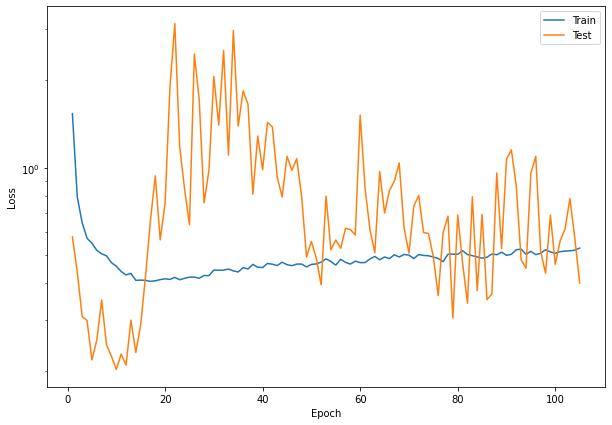

In [19]:
epochs = 1 + np.arange(len(train_loss_c))

plt.figure(figsize=(10, 7))
plt.plot(epochs, train_loss_c, label="Train")
plt.plot(epochs, test_loss_c, label="Test")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.yscale("log")
plt.legend()
plt.show()


#### Visualizations

Target Label: 9


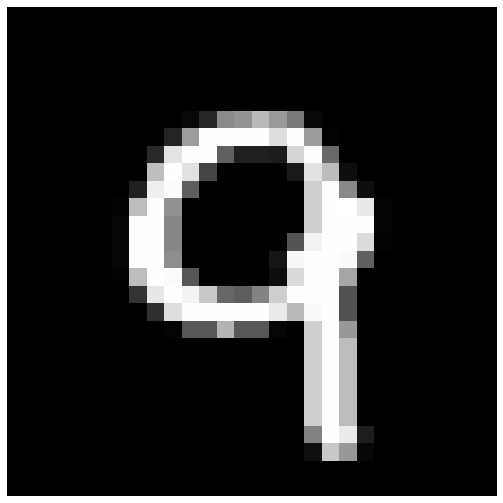

In [75]:
test_image, test_label = next(iter(dataloader))

# one image, one channel, 28x28 px
test_image = test_image[0].reshape(1, 1, 28, 28)
test_label = test_label[0].item()
print("Target Label:", test_label)

plt.figure(figsize=(10, 9))
# only the 28x28 px information here
plt.imshow(test_image[0][0], cmap="gray")
plt.axis("off")
plt.show()


#### Filtered Images

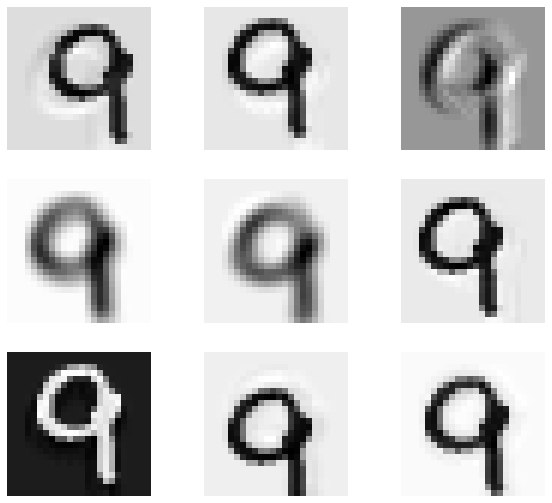

In [76]:
modules = [module for module in conv_model.modules() if not isinstance(module, torch.nn.Sequential)]

convolution = modules[1]

convoluted_image = convolution(test_image)

plt.figure(figsize=(10, 9))
for i in range(9):
    img = convoluted_image[0][i].detach().numpy()
    plt.subplot(3, 3, i + 1)
    plt.imshow(img, cmap="gray")
    plt.axis("off")
plt.show()


#### Corresponding Filter Weights

torch.Size([32, 1, 5, 5])


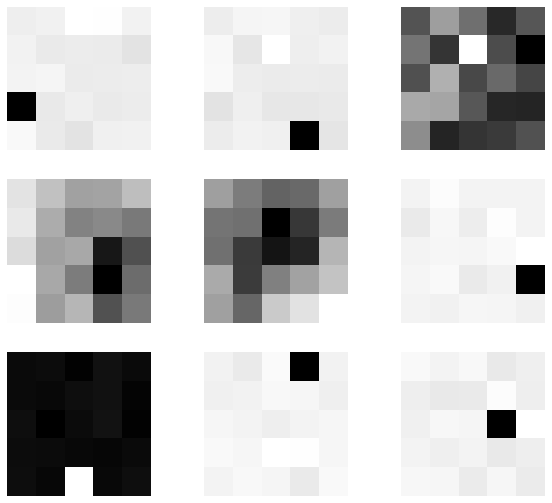

In [77]:
print(convolution.weight.shape)

plt.figure(figsize=(10, 9))
for i in range(9):
    img = convolution.weight[i][0].detach().numpy()
    plt.subplot(3, 3, i + 1)
    plt.imshow(img, cmap="gray")
    plt.axis("off")
plt.show()
